In [3]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [6]:
image = cv2.imread('test_img.jpeg')

In [13]:
w = image.shape[1]

In [14]:
# Points for the original image

src = np.float32([
    [225, 660],
    [590, 450], 
    [695, 450], 
    [1075, 660]
])
# Points for the new image
dst = np.float32([
    [400, 720],
    [400, 0], 
    [w-400, 0], 
    [w-400, 720]
])


def warper(img):
    
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def unwarp(img):
    
    # Compute and apply inverse perpective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)
    
    return unwarped

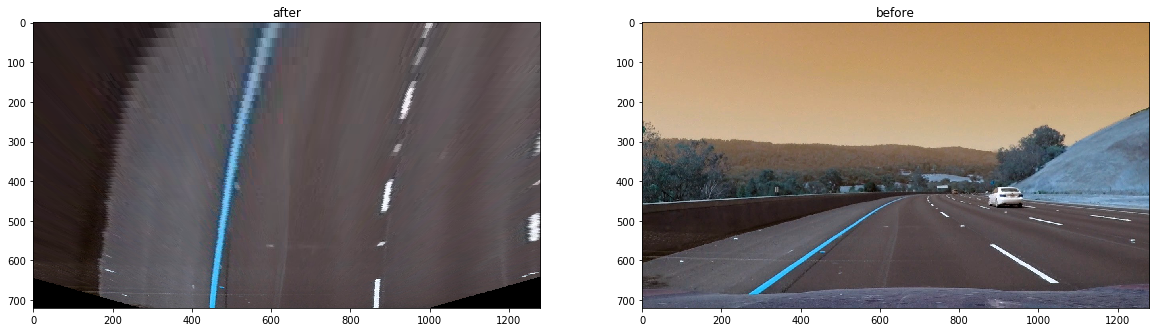

In [17]:
warped = warper(image)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(warped)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

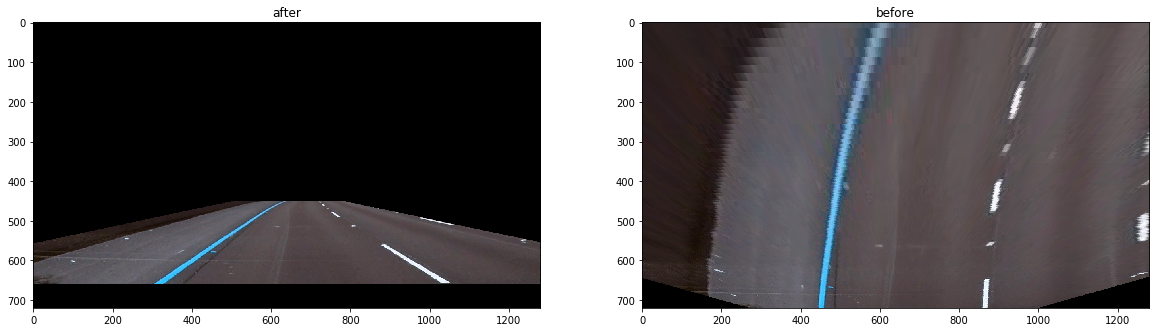

In [23]:
unwarped = unwarp(warped)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(unwarped)
plt.title('after')
plt.subplot(122),plt.imshow(warped)
plt.title('before')

plt.show()

In [24]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    isX = True if orient == 'x' else False
    sobel = cv2.Sobel(gray, cv2.CV_64F, isX, not isX)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return dir_binary

def apply_thresholds(image, ksize=3):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

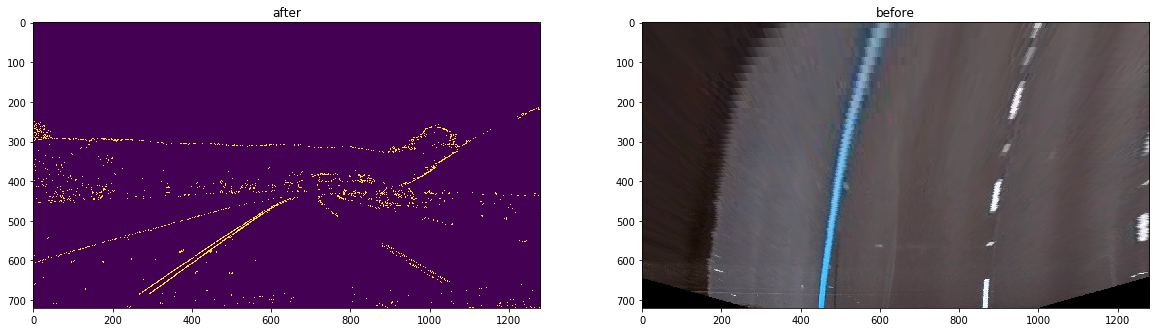

In [67]:
after_treshold = apply_thresholds(image)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(after_treshold)
plt.title('after')
plt.subplot(122),plt.imshow(warped)
plt.title('before')

plt.show()

In [68]:
def select_white_yellow(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hls, lower, upper)
    # yellow color mask
    low_yellow = np.uint8([10, 0, 100])
    up_yellow = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(hls, low_yellow, up_yellow)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    return mask

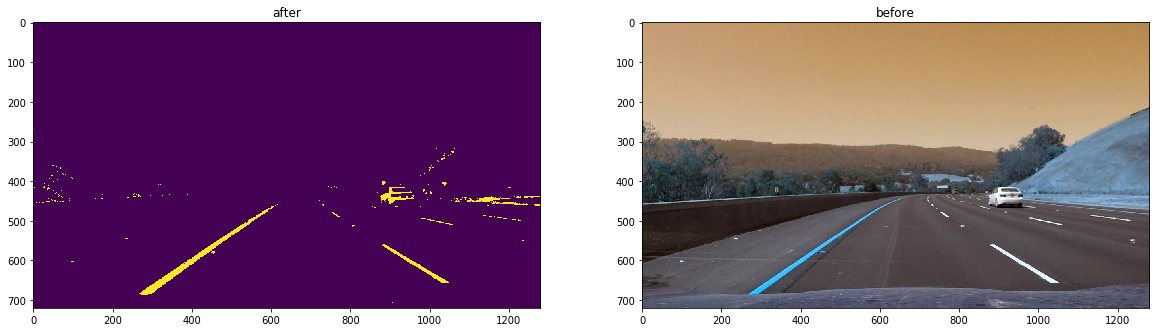

In [69]:
mask = select_white_yellow(image)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(mask)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

In [71]:
def combine_threshold(s_binary, combined):
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary

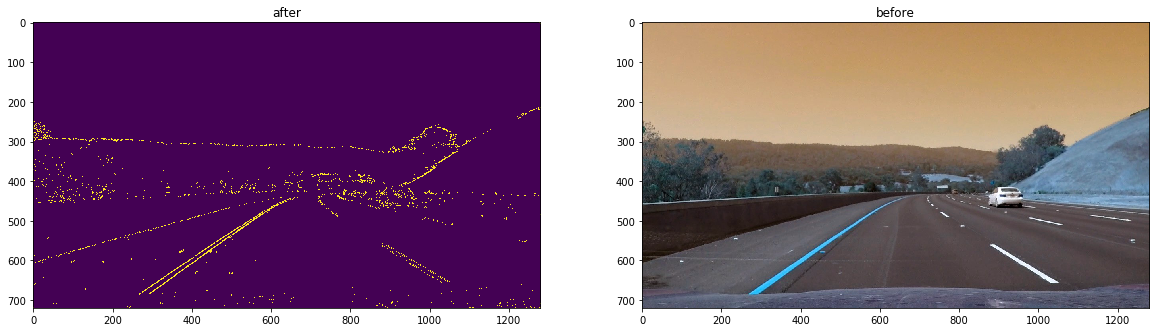

In [72]:
result = combine_threshold(select_white_yellow(image),apply_thresholds(image))
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(result)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()


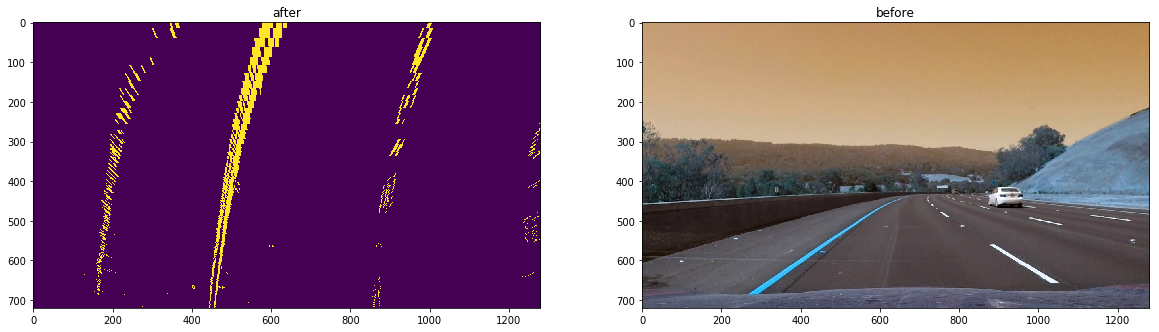

In [74]:
after_filter = combine_threshold(select_white_yellow(image),apply_thresholds(image))
warped = warper(after_filter)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(warped)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

In [75]:
def get_histogram(binary_warped):
    #apply histogram to half of img
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    return histogram

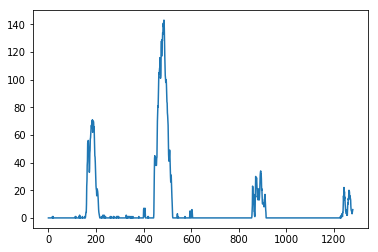

In [79]:
histogram = get_histogram(warped)
plt.plot(histogram)

In [77]:
# Use it for get real values lecture:
ym_per_pix = 30/720 # meters per pixel in y dimension
# xm_per_pix = 3.7/700 # meters per pixel in x dimension

# ym_per_pix = 3.0/100 # meters per pixel in y dimension, lane line is 10 ft = 3 meters
xm_per_pix = 3.7/550 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters

def calc_line_fits(img):

    ### Settings
    # Choose the number of sliding windows (for these images, the height is 450)
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, left_fit_m, right_fit_m, out_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


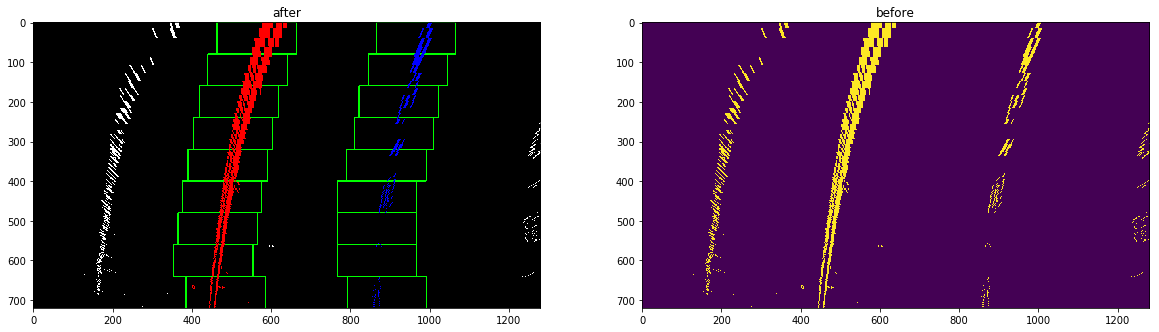

In [82]:
left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits(warped)

plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(out_img)
plt.title('after')
plt.subplot(122),plt.imshow(warped)
plt.title('before')

plt.show()

For make finding lanes we make this method

In [84]:
def calc_line_fits_from_prev(img, leftLine, rightLine):

    left_fit = leftLine.best_fit_px
    right_fit = rightLine.best_fit_px
    
    ### Settings
    margin = 100 # Width on either side of the fitted line to search

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))) 
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each in meters
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return left_fit, right_fit, left_fit_m, right_fit_m, result

# Calculation of distance and curve

In [85]:
def calc_radius(y_eval, left_fit, right_fit_cr):
    """
    left_fit and right_fit are assumed to have already been converted to meters
    """
    y_eval = y_eval * ym_per_pix
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def calc_center_dist(y_eval, midpoint, left_fit, right_fit):
        
    # Calculate the distance from the center
    x_left_line = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_line = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    
    position_from_center = ((x_left_line + x_right_line)/2 - midpoint) * xm_per_pix
    
    return position_from_center


In [87]:
img = cv2.imread('test_img.jpeg')
img_og = np.copy(img)
    
# Run this through our binary pipeline
after_filter = combine_threshold(select_white_yellow(image),apply_thresholds(image))
binary_warped = warper(after_filter)
    
    
# Run the warped, binary image from the pipeline through the fitter
left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits(binary_warped)
    
y_eval = binary_warped.shape[0]
midx = binary_warped.shape[1] / 2
left_curverad, right_curverad = calc_radius(y_eval, left_fit_m, right_fit_m)
center = calc_center_dist(y_eval, midx, left_fit, right_fit)
print("left: ", left_curverad)
print("right: ", right_curverad)

left:  599.0597522635342
right:  2898.099371852515


# Drawing lane area

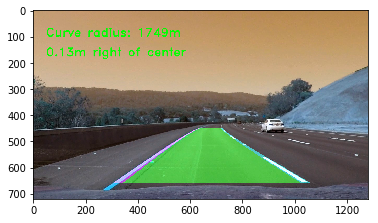

In [91]:
img = cv2.imread('test_img.jpeg')
img_og = np.copy(img)
    
# Run this through our binary pipeline
after_filter = combine_threshold(select_white_yellow(image),apply_thresholds(image))
binary_warped = warper(after_filter)
    
# Run the warped, binary image from the pipeline through the fitter
left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits(binary_warped)
    
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
y_eval = binary_warped.shape[0]
midx = binary_warped.shape[1] / 2
    
# calc the radius and center distance
left_curverad, right_curverad = calc_radius(y_eval, left_fit_m, right_fit_m)
center = calc_center_dist(y_eval, midx, left_fit, right_fit)

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=20)
cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=20)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = unwarp(color_warp)
# Combine the result with the original image
result = cv2.addWeighted(img_og, 1, newwarp, 0.5, 0)
    
curve_rad = (left_curverad + right_curverad) / 2.
    
# Add the radius and center
font = cv2.FONT_HERSHEY_DUPLEX
text = 'Curve radius: ' + '{:04.0f}'.format(curve_rad) + 'm'
cv2.putText(result, text, (50,100), font, 1.5, (0,255, 0), 2, cv2.LINE_AA)
if center < 0:
    dir = 'left'
else:
    dir = 'right'
text = '{:03.2f}'.format(center) + 'm '+ dir + ' of center'
cv2.putText(result, text, (50,175), font, 1.5, (0,255, 0), 2, cv2.LINE_AA)

plt.figure()
plt.imshow(result)